In [1]:
print("buenasera")

buenasera


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns


In [3]:
train_df = pd.read_csv('training.csv') # split for test and train set is ready
test = pd.read_csv('test.csv')

In [25]:
our_columns = list(set([1,10,11]+(list(range(18, 29))) + [12,14,15,16,17,29,30,31,32,33]))
df = train_df.iloc[:,our_columns]

y = df["IsBadBuy"]
X = df

del X["IsBadBuy"]

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


train = pd.DataFrame(X_train.join(y_train))
val = X_val.join(y_val)

In [6]:
val.head()

,Color,Transmission,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,...,VehOdo,Nationality,Size,TopThreeAmericanName,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
10580,BLUE,AUTO,4516.0,5335.0,7121.0,8140.0,3941.0,4754.0,7531.0,8885.0,...,78883,OTHER ASIAN,MEDIUM,OTHER,77041,TX,5685.0,0,569,0
27667,GOLD,AUTO,8500.0,10607.0,9680.0,11956.0,8500.0,10607.0,9680.0,11956.0,...,79278,AMERICAN,CROSSOVER,CHRYSLER,32824,FL,6645.0,0,1857,0
60595,GREEN,AUTO,3402.0,4477.0,6513.0,7728.0,3844.0,4895.0,6620.0,7897.0,...,92111,AMERICAN,SMALL SUV,FORD,92337,CA,5480.0,0,1353,0
60484,RED,AUTO,9959.0,11383.0,11256.0,12794.0,10942.0,12387.0,12317.0,13878.0,...,85427,AMERICAN,MEDIUM SUV,CHRYSLER,91752,CA,8375.0,0,1763,0
48363,GOLD,AUTO,7026.0,8385.0,11809.0,13980.0,7642.0,9380.0,12049.0,14091.0,...,82274,AMERICAN,VAN,GM,47129,IN,6475.0,0,2282,0


In [7]:
train.columns

Index(['Color', 'Transmission', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'WheelTypeID', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost',
       'IsBadBuy'],
      dtype='object')

In [8]:
train.groupby("Color")["IsBadBuy"].agg(["mean","count"]) # wygląda na to ze not avaiable color zwiększa szanse zlego zakupu, zas pomaranczowy kolor w dziwny sposob zmniejsza - ale jest tam dosyc malo danych

,mean,count
Color,,
BEIGE,0.139706,1088
BLACK,0.113936,5389
BLUE,0.115784,7229
BROWN,0.132890,301
GOLD,0.142626,3702
GREEN,0.118362,2222
GREY,0.116101,5478
MAROON,0.135135,1443
NOT AVAIL,0.253731,67


In [9]:
# na razie damy tylko kolumne czy jest bardziej niebezpieczna czy nie

color_train = train.groupby("Color")["IsBadBuy"].agg(["mean"]) 

max_mean_color = color_train["mean"].max()
color_dict = color_train["mean"].to_dict()
train["ColorDanger"] = train["Color"].map(color_dict).fillna(train.IsBadBuy.mean())/max_mean_color
bad_colors = list(color_train.loc[color_train["mean"] > train.IsBadBuy.mean()].index)

train['DangerousColor'] = np.where(train["Color"].isin(bad_colors), 1, 0)

przygotowanie imputacji

In [10]:
# zaimputujemy sobie wartość 0 dla kolumn MMRCurrentAuctionAveragePrice oraz MMRAcquisitionAuctionAveragePrice
# pozostałe wywalamy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train["MMRCurrentAuctionAveragePrice"] = np.where(train["MMRCurrentAuctionAveragePrice"] == 0, np.nan, train["MMRCurrentAuctionAveragePrice"])
train["MMRAcquisitionAuctionAveragePrice"] = np.where(train["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, train["MMRAcquisitionAuctionAveragePrice"])

imp_mean = IterativeImputer(random_state=0)

MMR_columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]

imp_mean.fit(train[MMR_columns])

MMR_train_transformed = imp_mean.transform(train[MMR_columns])
MMR_train_transformed = pd.DataFrame(MMR_train_transformed, columns = MMR_columns)
MMR_train_transformed.index = train.index
MMR_train_transformed

c:\Users\tymot\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,MMRCurrentAuctionAveragePrice,MMRAcquisitionAuctionAveragePrice,VehBCost
51596,6473.0,5602.0,6800.0
7358,8975.0,7038.0,10775.0
66010,6680.0,6680.0,6890.0
39674,6416.0,5820.0,6870.0
12486,5978.0,4836.0,7350.0
...,...,...,...
22569,8529.0,8168.0,6470.0
41811,3769.0,3720.0,5935.0
67791,6346.0,5560.0,7130.0
40656,5345.0,5512.0,8370.0


# preprocessing pipeline

In [11]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    X = X[X['WheelTypeID'].notna()]
    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
        
    return X

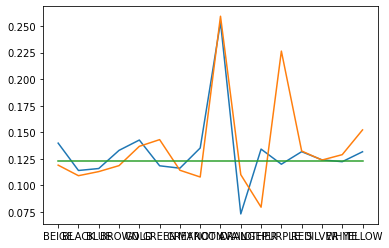

In [12]:
train_bad_buy_mean = train.IsBadBuy.mean()

color_val = val.groupby("Color")["IsBadBuy"].agg(["mean"])
color = color_val.join(color_train, lsuffix="_val", rsuffix="_train")
color["mean"] = train.IsBadBuy.mean()
plt.plot(color.index, color["mean_train"])
plt.plot(color.index, color["mean_val"])
plt.plot(color.index, color["mean"])

plt.show()

In [13]:
def encode_categorical(df):
    df["ColorDanger"] = df["Color"].map(color_dict).fillna(train_bad_buy_mean)/max_mean_color # no takie w miare to jest średnie
    #df['DangerousColor'] = np.where(df["Color"].isin(bad_colors), 1, 0)

    df["IsPrimeunitNA"] = np.where(df["PRIMEUNIT"].isna(), 1, 0) # to moze byc niepotrzebne
    primeunit_dict = {'NO':0, 'YES':1, float("nan"):0} # nie jestem pewien czy nie lepiej bedzie zamienic na odwrot
    df['PRIMEUNIT'] = df['PRIMEUNIT'].str.upper().map(primeunit_dict)
    aucguart_dict = {'GREEN':2, 'YELLOW':1, "RED":0, float("nan"):0}
    df['AUCGUART'] = df['AUCGUART'].str.upper().map(aucguart_dict)

    transmission_dict = {'AUTO':0, 'MANUAL':1}
    df['Transmission'] = df['Transmission'].str.upper().map(transmission_dict)
    df["Transmission"] = df["Transmission"].fillna(df["Transmission"].median())

    df = df.drop(columns=["BYRNO", "Color"])

    print("Categorical columns transformed.")

    return df

def impute_MMR(df):

    # zamieniamy 0 na nan    
    df["MMRCurrentAuctionAveragePrice"] = np.where(df["MMRCurrentAuctionAveragePrice"] == 0, np.nan, df["MMRCurrentAuctionAveragePrice"])
    df["MMRAcquisitionAuctionAveragePrice"] = np.where(df["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, df["MMRAcquisitionAuctionAveragePrice"])

    MMR_df = imp_mean.transform(df[MMR_columns])
    MMR_df = pd.DataFrame(MMR_df, columns = MMR_columns)
    MMR_df.index = df.index
    df["MMRCurrentAuctionAveragePrice"] = MMR_df["MMRCurrentAuctionAveragePrice"]
    df["MMRAcquisitionAuctionAveragePrice"] = MMR_df["MMRAcquisitionAuctionAveragePrice"]

    df = df.drop(columns = ["MMRAcquisitionAuctionCleanPrice", "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice", 
                            "MMRCurrentAuctionCleanPrice", "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice"]) 
    
    # tutaj moze tez MMRAcquisitionAuctionAveragePrice

    print("MMR Columns imputed.")
    return df

In [98]:
X["WheelTypeID"]

0       1.00
1       1.00
2       2.00
3       1.00
4       2.00
        ... 
72978   1.00
72979    NaN
72980   1.00
72981   1.00
72982   1.00
Name: WheelTypeID, Length: 72983, dtype: float64

In [99]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    #X = X[X['WheelTypeID'].notna()] TAK NIE WOLNO - to nam psuje preprocessing
    X['WheelTypeID'] = X['TopThreeAmericanName'].fillna(0)

    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
    
    return X

# pipe


In [100]:
train_df = pd.read_csv('training.csv') # split for test and train set is ready
test = pd.read_csv('test.csv')

In [101]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


train = X_train.join(y_train)
val = X_val.join(y_val)

In [102]:
X_train

,Color,Transmission,WheelTypeID,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
51596,WHITE,AUTO,3.00,84628,AMERICAN,MEDIUM SUV,FORD,5602.00,6952.00,6550.00,...,10117.00,11622.00,NaN,NaN,99750,80011,CO,6800.00,0,1893
7358,GREEN,AUTO,1.00,80410,AMERICAN,LARGE SUV,FORD,7038.00,8396.00,8101.00,...,13210.00,14948.00,NaN,NaN,18111,30272,GA,10775.00,0,1413
66010,MAROON,AUTO,1.00,72867,OTHER ASIAN,MEDIUM,OTHER,6680.00,8658.00,7714.00,...,7714.00,9851.00,NaN,NaN,17675,28273,NC,6890.00,0,803
39674,WHITE,AUTO,2.00,65177,AMERICAN,MEDIUM,GM,5820.00,6806.00,9205.00,...,9920.00,11235.00,NaN,NaN,20234,85353,AZ,6870.00,0,923
12486,GREY,AUTO,1.00,53748,AMERICAN,MEDIUM,GM,4836.00,5756.00,7912.00,...,9174.00,10605.00,NaN,NaN,21053,95673,CA,7350.00,0,837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22569,RED,AUTO,1.00,94600,AMERICAN,SMALL SUV,FORD,8168.00,10259.00,12807.00,...,12340.00,14238.00,NaN,NaN,17212,76040,TX,6470.00,0,1053
41811,GREY,AUTO,1.00,70813,AMERICAN,COMPACT,FORD,3720.00,4917.00,6568.00,...,6902.00,7547.00,NO,GREEN,5546,33619,FL,5935.00,0,1155
67791,BLUE,AUTO,2.00,45605,OTHER ASIAN,MEDIUM,OTHER,5560.00,6203.00,9148.00,...,9810.00,10073.00,NaN,NaN,25100,78754,TX,7130.00,0,482
40656,WHITE,AUTO,1.00,66189,AMERICAN,LARGE SUV,FORD,5512.00,6802.00,6453.00,...,6273.00,7931.00,NaN,NaN,18111,29532,SC,8370.00,0,1223


In [103]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['VehOdo','VehBCost', 'WarrantyCost']),
        ('cat', OneHotEncoder(),  ['TopThreeAmericanName', 'WheelTypeID','Nationality','Size']),
        ('passthrough','passthrough', ['IsOnlineSale'])
    ])


,Color,Transmission,WheelTypeID,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
51596,WHITE,AUTO,3.00,84628,AMERICAN,MEDIUM SUV,FORD,5602.00,6952.00,6550.00,...,11622.00,NaN,NaN,99750,80011,CO,6800.00,0,1893,0
7358,GREEN,AUTO,1.00,80410,AMERICAN,LARGE SUV,FORD,7038.00,8396.00,8101.00,...,14948.00,NaN,NaN,18111,30272,GA,10775.00,0,1413,0
66010,MAROON,AUTO,1.00,72867,OTHER ASIAN,MEDIUM,OTHER,6680.00,8658.00,7714.00,...,9851.00,NaN,NaN,17675,28273,NC,6890.00,0,803,0
39674,WHITE,AUTO,2.00,65177,AMERICAN,MEDIUM,GM,5820.00,6806.00,9205.00,...,11235.00,NaN,NaN,20234,85353,AZ,6870.00,0,923,1
12486,GREY,AUTO,1.00,53748,AMERICAN,MEDIUM,GM,4836.00,5756.00,7912.00,...,10605.00,NaN,NaN,21053,95673,CA,7350.00,0,837,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22569,RED,AUTO,1.00,94600,AMERICAN,SMALL SUV,FORD,8168.00,10259.00,12807.00,...,14238.00,NaN,NaN,17212,76040,TX,6470.00,0,1053,0
41811,GREY,AUTO,1.00,70813,AMERICAN,COMPACT,FORD,3720.00,4917.00,6568.00,...,7547.00,NO,GREEN,5546,33619,FL,5935.00,0,1155,0
67791,BLUE,AUTO,2.00,45605,OTHER ASIAN,MEDIUM,OTHER,5560.00,6203.00,9148.00,...,10073.00,NaN,NaN,25100,78754,TX,7130.00,0,482,0
40656,WHITE,AUTO,1.00,66189,AMERICAN,LARGE SUV,FORD,5512.00,6802.00,6453.00,...,7931.00,NaN,NaN,18111,29532,SC,8370.00,0,1223,0


In [104]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

categorical_transformer = FunctionTransformer(encode_categorical)
MMR_imputer = FunctionTransformer(impute_MMR)
mateusz_transformer = FunctionTransformer(preprocess_df)

# all the afore declared processings applied
prepipe = Pipeline([
    ("transform_categorical", categorical_transformer),
    ("MMR_imputing", MMR_imputer), 
    ("Mateusz", mateusz_transformer)
])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [105]:
X_train = prepipe.fit_transform(X_train)
X_train = pipeline.fit_transform(X_train)


Categorical columns transformed.
MMR Columns imputed.


In [106]:
X_train

<51088x28 sparse matrix of type '<class 'numpy.float64'>'
	with 358854 stored elements in Compressed Sparse Row format>

In [107]:
# validation dataset

X_val = prepipe.transform(X_val)
X_val = pipeline.transform(X_val)


Categorical columns transformed.
MMR Columns imputed.


# model selection

to nie dziala ale idk czemu

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [49]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_val, y_train, y_val)
models

100%|██████████| 29/29 [48:59<00:00, 101.37s/it]  


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,


In [51]:
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,


random forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [111]:
y_pred = rf_model.predict(X_val)

In [112]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93     21218
           1       0.07      0.26      0.10       677

    accuracy                           0.86     21895
   macro avg       0.52      0.57      0.51     21895
weighted avg       0.95      0.86      0.90     21895



In [113]:
confusion_matrix(y_val, y_pred)

array([[18701,   501],
       [ 2517,   176]], dtype=int64)

# final predictions

In [114]:
test = pd.read_csv('test.csv')

In [115]:
test_columns =  [i - 1 for i in list(set([10,11]+(list(range(18, 29))) + [12,14,15,16,17,29,30,31,32,33]))] 

X_test = test.iloc[:, test_columns].copy()
X_test

,Color,Transmission,WheelTypeID,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,SILVER,AUTO,1.00,85377,AMERICAN,LARGE,GM,5032.00,6386.00,5935.00,...,8557.00,9752.00,NaN,NaN,18881,30212,GA,6500.00,0,2152
1,SILVER,AUTO,1.00,61873,AMERICAN,MEDIUM,GM,4502.00,5685.00,5362.00,...,7562.00,9296.00,NaN,NaN,18111,30212,GA,6300.00,0,1118
2,SILVER,AUTO,1.00,69283,AMERICAN,MEDIUM SUV,CHRYSLER,10244.00,13041.00,11564.00,...,15340.00,16512.00,NaN,NaN,18111,30212,GA,9700.00,0,1215
3,GOLD,AUTO,1.00,87889,AMERICAN,MEDIUM,GM,2558.00,3542.00,3263.00,...,5725.00,6398.00,NaN,NaN,18881,30212,GA,4150.00,0,1933
4,BLUE,AUTO,NaN,73432,OTHER ASIAN,COMPACT,OTHER,5013.00,6343.00,5914.00,...,5914.00,7350.00,NaN,NaN,18111,30212,GA,4100.00,0,920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48702,BLACK,AUTO,1.00,88645,AMERICAN,LARGE,FORD,5358.00,6836.00,8987.00,...,9764.00,11395.00,NaN,NaN,20928,33411,FL,7955.00,0,1633
48703,GREEN,AUTO,2.00,81862,TOP LINE ASIAN,COMPACT,OTHER,6849.00,7992.00,10999.00,...,10283.00,11565.00,NaN,NaN,20928,33411,FL,7035.00,0,594
48704,BLACK,AUTO,2.00,82451,OTHER ASIAN,MEDIUM,OTHER,4662.00,5655.00,7972.00,...,7871.00,9490.00,NO,GREEN,20928,33411,FL,6335.00,0,594
48705,SILVER,AUTO,1.00,75760,OTHER ASIAN,MEDIUM,OTHER,5953.00,8166.00,9137.00,...,8576.00,9937.00,NO,GREEN,20928,33411,FL,8055.00,0,1038


In [119]:
X_test = prepipe.transform(X_test)
X_test = pipeline.transform(X_test)

Categorical columns transformed.
MMR Columns imputed.


In [120]:
y = rf_model.predict(X_test)
pd.DataFrame(y, columns=["IsBadBuy"]).join(test["RefId"]).to_csv("out.csv", index=False)